In [1]:
# tutorials page
# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Geometric_deep_learning

# website
# https://uvadl2c.github.io/lectures-2022.html


### 0. Installing and importing

In [2]:
# Standard libraries
import os
import numpy as np
import math
from PIL import Image
from functools import partial


# Import for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning 
                            #installed by defalult. Hence, we install if nessesary
        !pip install pytorch-lightning==1.5.1
        import pytorch_lightning as pl
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [3]:
torch.__path__

['/Users/temporary/Documents/GitHub/pytorch-intel-mps/torch']

In [4]:
# Path to the folder where the datasets are be downloaded ( e. g. MNIST)
DATASET_PATH = "./data"

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") #if torch.backends.mps.is_available() else torch.device("cpu")


In [5]:
device

device(type='cpu')

In [6]:
import urllib.request
from urllib.error import HTTPError

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/DL2/GDL/"

# Files to download
files = ['paprika.tiff']

# For each file, check whether it already exists. If not, try downloading it
for file_name in files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder,")
            print("or contact the author with the full output including the following error:\n", e)

## 1. Implementing group in python

### 1.0 Base class

In [7]:
class GroupBase(torch.nn.Module):
    
    def __init__(self, dimension, identity):
        """Implementing a group
        
        @param dimension: Dimensionality of the group (number of dimensions in the basis of the algebra).
        @param identity: Identity element of the group
        
        """
        super().__init__()
        self.dimension = dimension
        self.register_buffer('identity', torch.Tensor(identity))
        self.identity.to(device)
        
        
    def elements(self):
        """Obtain a tensor containing all group elements in this group
        
        """
        
        raise NotImplementedError()
        
    def product(self, h, h_prime):
        """ Defines group product on two group elements.
        
        @param h: group element 1 
        @param h_prime: group element 2
        
        """
        
        raise NotImplementedError()
        
    def inverse(self, h):
        
        """ Defines inverse for group element 
        
        @ param h: A group element from subgroup H
        
        """
        
        raise NotADirectoryError()
        
    
    def left_action_on_R2(self, h, x):
        """ Group action of an element from the subgroup H on a vector in R2.

        @param h: A group element from subgroup H.
        @param x: Vectors in R2.
        """
        
        raise NotImplementedError()
        
    
    
    def determinant(self, h):
        """Calculate the determinant of the representation of a group element h.
        
        
        @param h: group element
        """
        
        raise NotImplementedError()
        
    def normalize_group_parametrization(self, h):
        """ Map the group elements to an interval [-1, 1]. We use this to create
        a standardized input for obtaining weights over the group
        
        
        @param h: group element
        """
        
        raise NotImplementedError()

### 1.1 C4 implementation

In [8]:
class CyclicGroup(GroupBase):
    
    def __init__(self, order):
        """Implementing a group
        
        @param dimension: Dimensionality of the group (number of dimensions in the basis of the algebra).
        @param identity: Identity element of the group
        
        """
        super().__init__(dimension = 1, identity = [0.])
        
        assert order > 1
        
        self.order = torch.tensor(order)
        
    def elements(self):
        """Obtain a tensor containing all group elements in this group.
        
        
        @ return elements: Tensor containing group elements of shape [self.order]
        """
        
        return torch.linspace(start = 0, 
                              end = 2 * np.pi * float(self.order - 1) / float(self.order),
                              steps = self.order
        ).to(device)
    
        
    def product(self, h, h_prime):
        """ Defines group product on two group elements of the cyclic group C4.
        
        @param h: group element 1 
        @param h_prime: group element 2
        
        @ returns product: Tensor containing h \cdot h_prime with \cdot the group action
        """
        
        product = (h + h_prime) % (2 * np.pi)
        
        return product
        
        
    def inverse(self, h):
        
        """ Defines inverse for group element of the cyclic group C4
        
        @ param h: A group element 
        
        @ returns inverse: Tensor containing h^{-1}
        """
        
        inverse = (-h) % (2 * np.pi)
        
        return inverse
        
    
    def left_action_on_R2(self, h, x):
        """ Group action of an element from the subgroup H on a vector in R2.

        @param h: A group element from subgroup H.
        @param x: Vectors in R2.
        
        @ returns transformed_x: Tensor containing \rho(h) x.
        """
        
        # Transform the vector x with h, recall that we are working with a left-regular representation,
        # meaning we transform vectors in R^2 through left-matrix multiplication
        transformed_x = torch.tensordot(self.matrix_representation(h), x, dims = 1)
        return transformed_x
    
    def matrix_representation(self, h):
        """ Obtain a matrix representation in R^2 for an element h.
        
        @ param h: A group element.
        
        @returns representation: Tensor containing matrix representation of h, shape [2, 2]
        """
        cos_t = torch.cos(h)
        sin_t = torch.sin(h)
    
    
        representation = torch.tensor([[cos_t, -sin_t], [sin_t, cos_t]], device = self.identity.device)
        
        return representation
    
    
        
    def normalize_group_elements(self, h):
        """ Map the group elements to an interval [-1, 1]. We use this to create
        a standardized input for obtaining weights over the group
        
        
        @param h: group element
        
        @return normalized_h: Tensor containing normalized value corresponding to element h
        """
        largest_elem = 2 * np.pi * (self.order - 1) / self.order
        normalized_h = (2*h / largest_elem) - 1
        
        return normalized_h

### 1.2 tests

In [9]:
# Some tests to verify our implementation
c4 = CyclicGroup(order = 4).to(device)

e, g1, g2, g3 = c4.elements()

assert c4.product(e, g1) == g1 and c4.product(g1, g2) == g3
assert c4.product(g1, c4.inverse(g1)) == e


# torch allclose determines if elements in the matrix are close to each other
assert torch.allclose(c4.matrix_representation(e), torch.eye(2).to(device))
assert torch.allclose(c4.matrix_representation(g2), torch.tensor([[-1., 0.], [0., -1.]]).to(device), atol = 1e-6)

assert torch.allclose(c4.left_action_on_R2(g1, torch.tensor([0., 1.]).to(device)), torch.tensor([-1., 0]).to(device), atol = 1e-7)

### 1.3 visualization

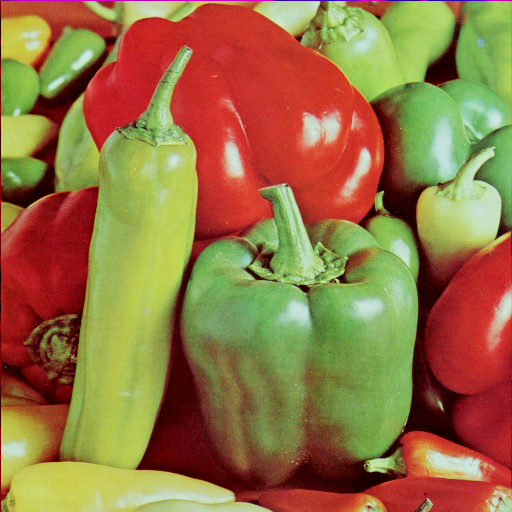

In [10]:
# Load image from disk.
img = Image.open(os.path.join(CHECKPOINT_PATH, 'paprika.tiff'))

# Convert to torch tensor.
img_tensor = transforms.ToTensor()(img)
img

In [11]:
def roll(x, shifts, dims):
    """Implements the torch roll operation on a singe dimension"""
    old_ind = torch.Tensor([el for el in range(x.shape[dims])]).long()
    new_ind = (old_ind + shifts) % x.shape[dims]
    
    if dims == -1: 
        return x[..., new_ind]
    else:
        raise NotImplementedError

x = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8]).view(4, 2)
#print(x)
#roll(x, 1, -1)

In [12]:
def bilinear_interpolation(signal, grid):
    """ Obtain signal values for a set of gridpoints through bilinear interpolation
    
    @param signal: Tensor containing pixel values [C, H, W] or [N, C, H, W]
    @param grid: Tensor containing coordinate values [2, Hf, Wf] or [2, N, Hf, Wf]
    
    @return signal_out: Tensor containing pixel values [C, Hf, Wf] or [N, C, Hf, Wf] 
    """
    # If signal or grid is a 3D array, add a dimension to support grid_sample.
    # This means adding batch dimension
    if len(signal.shape) == 3:
        signal = signal.unsqueeze(0)
    if len(grid.shape) == 3:
        grid = grid.unsqueeze(1)
        
    # Grid sample expects [N, H, W, 2] instead of [2, N, H, W]
    grid = grid.permute(1, 2, 3, 0)
    
    # Grid sample expects YX instead of XY
    grid = torch.roll(grid, shifts = 1, dims = -1)
    
    signal_out = torch.nn.functional.grid_sample(signal, 
                                                 grid, 
                                                 padding_mode='zeros',
                                                 align_corners = True,
                                                 mode = 'bilinear',
                                                )
    
    
    return signal_out
    
def trilinear_interpolation(signal, grid):
    """ Obtain signal values for a set of gridpoints through trilinear interpolation
    
    @param signal: Tensor containing pixel values [C, D, H, W] or [N, C, D, H, W]
    @param grid: Tensor containing coordinate values [2, Df, Hf, Wf] or [2, N, Df, Hf, Wf]
    
    @return signal_out: Tensor containing pixel values [C, Df, Hf, Wf] or [N, C, Df, Hf, Wf] 
    """
    # If signal or grid is a 3D array, add a dimension to support grid_sample.
    # This means adding batch dimension
    if len(signal.shape) == 4:
        signal = signal.unsqueeze(0)
    if len(grid.shape) == 4:
        grid = grid.unsqueeze(1)
        
    # Grid sample expects [N, H, W, 2] instead of [2, N, H, W]
    grid = grid.permute(1, 2, 3, 4, 0)
    
    # Grid sample expects YX instead of XY
    grid = torch.roll(grid, shifts = 1, dims = -1)
    
    signal_out = torch.nn.functional.grid_sample(signal, 
                                                 grid, 
                                                 padding_mode='zeros',
                                                 align_corners = True,
                                                 mode = 'bilinear', # actually trilinear in this case ...
                                                )
    
    
    return signal_out

In [13]:
# This creates a grid of the pixel location in our image of [2, 512, 512] since
# our image is 2 dimensional and has a width and height of 512 pixels.
img_grid = torch.stack(torch.meshgrid(
    torch.linspace(-1, 1, img_tensor.shape[-2]),
    torch.linspace(-1, 1, img_tensor.shape[-1]),
    indexing='ij'
))


# Let's create the group of 90 degree clockwise rotations
c4 = CyclicGroup(order=4)
e, g1, g2, _ = c4.elements()

# Create a counterclockwise rotation of 270 degrees using only e, g1 and g2
g3 = c4.product(g1, g2)

assert g3 == c4.elements()[-1]

In [14]:
# Transform the image grid we just created with the matrix representation of
# this group element.
transformed_img_grid = c4.left_action_on_R2(c4.inverse(g3), img_grid)

# Sample the image on the transformed grid points
transformed_img = bilinear_interpolation(img_tensor, transformed_img_grid)[0]

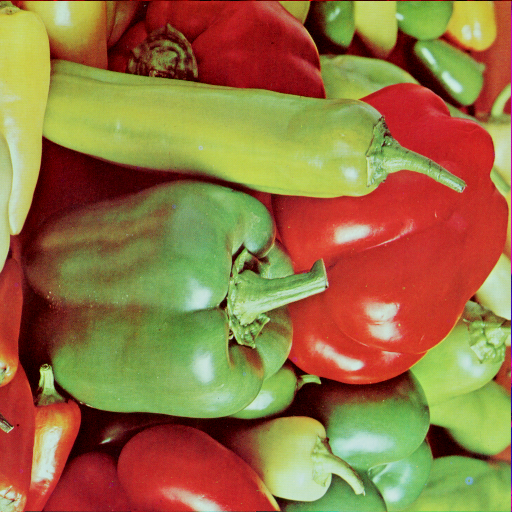

In [15]:
# If we turn this back to a PIL image we can see the result of our transformation!
transforms.ToPILImage()(transformed_img)

## Group Equvariant Convolutional Networks

### Lifting convolution

In [16]:
class LiftingKernelBase(torch.nn.Module):
    def __init__(self, group, kernel_size, in_channels, out_channels):
        """ Implements a base class for the lifting kernel. Stores R^2 grid 
        over which the lifting kernel is defined and it's transformed copies
        under the action of a group H
        
        """
        super().__init__()
        self.group = group
        
        
        print(self.group.identity.device)
        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # Creating spatial kernel grid. There are the coordinates on which our
        # kernel weights are defined
        self.register_buffer("grid_R2", torch.stack(torch.meshgrid(
            torch.linspace(-1. ,1., self.kernel_size),
            torch.linspace(-1. ,1., self.kernel_size),
            indexing = 'ij'
        )).to(self.group.identity.device))
        
        # Transform the grid by the elements in this group
        self.register_buffer("transformed_grid_R2", self.create_transformed_grid_R2())
        
    def create_transformed_grid_R2(self):
        """ Transform the created grid by the group action of each group element.
        This yields a grid (over H) of spatial grids (over R2). In other words,
        a list of grids, each index of which is the original spatial grid transformed by
        a corresponding group element of H 
        
        """
        
        group_elements = self.group.elements()
        
        transformed_grid = torch.stack([self.group.left_action_on_R2(el, self.grid_R2) for el in self.group.inverse(group_elements)], dim = 1)
        
        return transformed_grid
    
    def sample(self, sampled_group_elements):
        """ Sample convolution kernels for a given number of group elements
        
        
        arguments should include:
        @param sampled_group_elements: the group elements over which to sample
            the convolution kernels
            
        should return:
        @return kernels: filter band extending over all input channels,
            containing kernels transformed for all output group elements.
        """
        
        raise NotImplementedError()

In [17]:
torch.manual_seed(0)
order = 4
lifting_kernel_base = LiftingKernelBase(
    group = CyclicGroup(order=order).to(device),
    kernel_size=7,
    in_channels = 3,
    out_channels = 1
)

assert lifting_kernel_base.transformed_grid_R2.shape == torch.Size([2, 4, 7, 7])

cpu


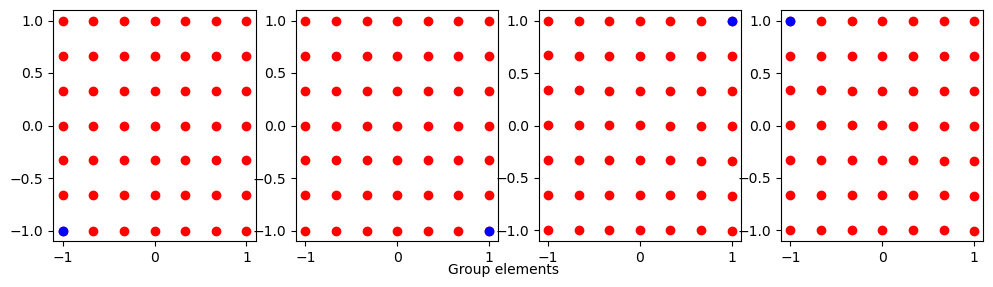

In [18]:
plt.rcParams['figure.figsize'] = [12, 3]

# Create [group_elements] figures
fig, ax = plt.subplots(1, order)

# Get the grid
transformed_grip_R2 = lifting_kernel_base.transformed_grid_R2

# Visualize the transformed kernel grid. We mark the same cornerpoint by a
# blue 'x' in all grids as reference point

for group_elem in range(order):
    ax[group_elem].scatter(
        transformed_grip_R2.cpu()[1, group_elem, :, :],
        transformed_grip_R2.cpu()[0, group_elem, :, :],
        c = 'r'
    )
    # Mark a corner point so we can see it transform.
    ax[group_elem].scatter(
        transformed_grip_R2.cpu()[1, group_elem, 0, 0],
        transformed_grip_R2.cpu()[0, group_elem, 0, 0],
        c = 'b'
    )
    
fig.text(0.5, 0., 'Group elements', ha = 'center')
plt.show()

In [19]:
class InterpolativeLiftingKernel(LiftingKernelBase):
    
    def __init__(self, group, kernel_size, in_channels, out_channels):
        super().__init__(group, kernel_size, in_channels, out_channels)
        
        # Create and initialize a set of weights, we will interpolate these
        # to create our transformed spatial kernels
        self.weight = torch.nn.Parameter(torch.zeros((
            self.out_channels,
            self.in_channels,
            self.kernel_size,
            self.kernel_size,
        ), device = self.group.identity.device))
        
        # Initialize weights using kaiming uniform inialization
        torch.nn.init.kaiming_uniform_(self.weight.data, a = math.sqrt(5))
        
    def sample(self):
        """ Sample convolution kernels for a given number of group elements
        
        
        should return:
        @return kernels: filter bank extending over all input channels,
            containing kernels transformed for all output group elements
        """
        # First, we fold the output channel dim into input channel dim.
        weight = self.weight.view(
            self.out_channels*self.in_channels,
            self.kernel_size,
            self.kernel_size
        )
        
        transformed_weight = []
        for spatial_grid_idx in range(self.group.elements().numel()):
            transformed_weight.append(
                bilinear_interpolation(weight, self.transformed_grid_R2[:, spatial_grid_idx, :, :])
            )
            
        transformed_weight = torch.stack(transformed_weight)
        
        # Separate input and output channels.
        transformed_weight = transformed_weight.view(
            self.group.elements().numel(),
            self.out_channels,
            self.in_channels,
            self.kernel_size,
            self.kernel_size
        )
        
        # Put out channel dimension  before group dimension. We do this
        # to be able to use pytorched Conv2D. Details below!
        transformed_weight = transformed_weight.transpose(0, 1)
        
        return transformed_weight

In [20]:
torch.manual_seed(0)

ik = InterpolativeLiftingKernel(
    group = CyclicGroup(order = 4).to(device),
    kernel_size=7,
    in_channels=2,
    out_channels = 1
)

weights = ik.sample()
weights.shape

cpu


torch.Size([1, 4, 2, 7, 7])

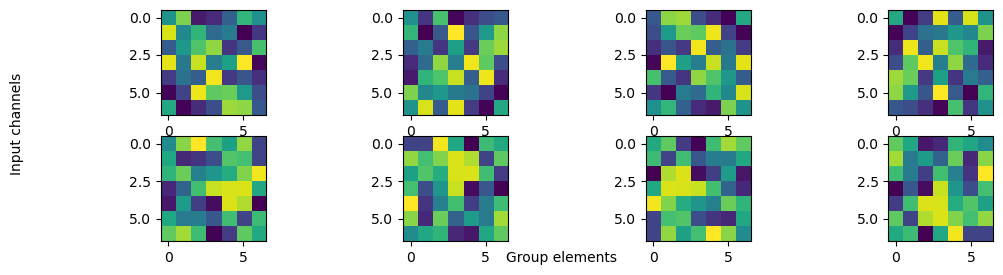

In [21]:
# Pick an output channel to visualize
out_channel_idx = 0
    
# Create [in_channels, group_elements] figures
fig, ax = plt.subplots(ik.in_channels, ik.group.elements().numel())


for in_channel in range(ik.in_channels):
    for group_elem in range(ik.group.elements().numel()):
        ax[in_channel, group_elem].imshow(
            weights[out_channel_idx, group_elem, in_channel, :, :].cpu().detach().numpy()
        )
        
fig.text(0.5, 0.04, 'Group elements', ha = 'center')
fig.text(0.04, 0.5, 'Input channels', va = 'center', rotation = 'vertical')

plt.show()

In [22]:
class LiftingConvolution(torch.nn.Module):
    
    def __init__(self, group, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        
        self.kernel = InterpolativeLiftingKernel(
            group = group,
            kernel_size = kernel_size,
            in_channels = in_channels,
            out_channels = out_channels
        )
        
        self.padding = padding
        
    def forward(self, x):
        """ Perform lifting convolution
        
        @ param x: Input sample [batch_dim, in_channels, spatial_dim_1,
                spatial_dim_2]
        
        @ return: Function on a homogeneous space of the group
            [batch_dim, out_channels, num_group_elements, spatial_dim_1,
            spatial_dim_2]
        """
        
        conv_kernels = self.kernel.sample().reshape(
            self.kernel.out_channels*self.kernel.group.elements().numel(),
            self.kernel.in_channels,
            self.kernel.kernel_size,
            self.kernel.kernel_size
        )
        
        conv_kernels = conv_kernels
        
        x = torch.nn.functional.conv2d(
            input = x, 
            weight = conv_kernels, 
            padding = self.padding)
        
        x = x.view(
            -1,
            self.kernel.out_channels, 
            self.kernel.group.elements().numel(),
            x.shape[-1],
            x.shape[-2]
        )
        
        
        return x

In [23]:
torch.manual_seed(0)
lifting_conv = LiftingConvolution(
    group = CyclicGroup(order=4).to(device),
    kernel_size=5,
    in_channels=3,
    out_channels=8,
    padding=False
)

cpu


### 2.2 Group Convolution

In [24]:
class GroupKernelBase(torch.nn.Module):
    
    def __init__(self, group, kernel_size, in_channels, out_channels):
        """ Implements base class for the group convolution kernel.stores grid 
        defined over the group R^2 \rtimes H and it's transformed copies under 
        all elements of the group H
        
        """
        super().__init__()
        self.group = group
        
        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # Create a spatial kernel grid
        self.register_buffer("grid_R2", torch.stack(torch.meshgrid(
            torch.linspace(-1., 1., self.kernel_size),
            torch.linspace(-1., 1., self.kernel_size),
            indexing = 'ij'
        )).to(self.group.identity.device))
        
        # The kernel grid now also extends over the group H, as our input
        # feature maps contain an additional group dimension
        self.register_buffer("grid_H", self.group.elements())
        self.register_buffer("transformed_grid_R2xH", self.create_transformed_grid_R2xH())
        
        
    def create_transformed_grid_R2xH(self):
        """ Transform the created grid over R^2 \rtimes H by the group action of
        each group element in H
        
        This yields a set of grids over the group. In other words, a list of
        grids, each index of which is the original grid over G transformed by 
        a corresponding group element in H.
        """
        
        # Sample the group H.
        group_elements = self.grid_H
        
        
        # Transform the grid defined over R2 with the sampled group elements.
        # We again would like to end up with a grid of shape [2, |H|, kernel_size, kernel_size].
        transformed_grip_R2 = torch.stack([self.group.left_action_on_R2(el, self.grid_R2) for el in self.group.inverse(group_elements)], dim = 1)
        
        # Transform the grid defined over H with the sampled group elements. We want a grid of 
        # shape [|H|, |H|]. Make sure to stack the transformed like above (over the 1st dim).
        transformed_grid_H = torch.stack([self.group.product(el, group_elements) for el in self.group.inverse(group_elements)], dim = 1)
        
        # Rescale values to between -1 and 1, we do this to please the torch
        # grid_sample function.
        transformed_grid_H = self.group.normalize_group_elements(transformed_grid_H)
        
        # Create a combined grid as the product of the grids over R2 and H
        # repeat R2 along the group dimension, and repeat H along the spatial dimension
        # to create a [3, |H|, |H|, kernel_size, kernel_size] grid
        transformed_grid = torch.cat(
            (
                transformed_grip_R2.view(
                    2,
                    group_elements.numel(),
                    1,
                    self.kernel_size,
                    self.kernel_size
                ).repeat(1, 1, group_elements.numel(), 1, 1),
                transformed_grid_H.view(
                    1,
                    group_elements.numel(),
                    group_elements.numel(),
                    1,
                    1,
                ).repeat(1, 1, 1, self.kernel_size, self.kernel_size)
            ),
            dim = 0
        )
        
        
        
        return transformed_grid
    
    def sample(self, sampled_group_elements):
        """ Sample convolution kernels for a given number of group elements
        
        arguments should include:
        @param sampled_group_elements: the group elements over which to sample
            the convolution kernels
            
        should return:
        @ return kernels: filter bank extending over all input channels,
            containing kernels transformed for all output group elements.
        """
        
        raise NotImplementedError()

In [25]:
gk_base = GroupKernelBase(
    group = CyclicGroup(order = 4).to(device),
    kernel_size = 7,
    in_channels = 1,
    out_channels = 1
)

gk_base.transformed_grid_R2xH.shape

torch.Size([3, 4, 4, 7, 7])

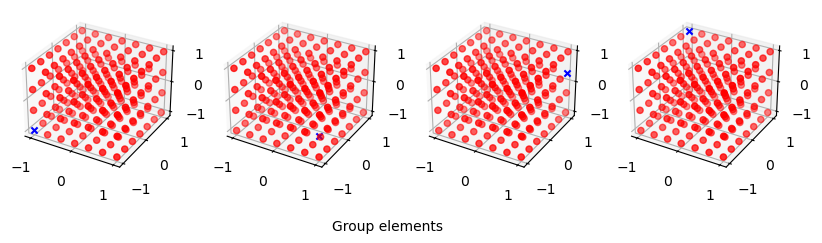

In [26]:
plt.rcParams['figure.figsize'] = [10, 3]


# Create [group_elements] figures.
fig, ax = plt.subplots(
    1,
    gk_base.group.elements().numel(),
    subplot_kw = dict(projection = '3d')
)

# Flatten spatial and group grid dimensions.
transformed_grid_R2xH = gk_base.transformed_grid_R2xH.reshape(
    3,
    gk_base.group.elements().numel(),
    gk_base.group.elements().numel() * gk_base.kernel_size * gk_base.kernel_size
)

# Visualize the transformed kernel grids. We mark the same row by a blue 'x' 
# in all grids as reference point.
for group_elem in range(gk_base.group.elements().numel()):
    ax[group_elem].scatter(transformed_grid_R2xH[1, group_elem, 1:].cpu(),
                           transformed_grid_R2xH[0, group_elem, 1:].cpu(),
                           transformed_grid_R2xH[2, group_elem, 1:].cpu(),
                           c = 'r')
    
    ax[group_elem].scatter(transformed_grid_R2xH[1, group_elem, 0].cpu(),
                           transformed_grid_R2xH[0, group_elem, 0].cpu(),
                           transformed_grid_R2xH[2, group_elem, 0].cpu(),
                           marker='x',
                           c = 'b')
    
fig.text(0.5, 0.04, 'Group elements', ha = 'center')

plt.show()

In [27]:
class InterpolativeGroupKernel(GroupKernelBase):
    
    def __init__(self, group, kernel_size, in_channels, out_channels):
        super().__init__(group, kernel_size, in_channels, out_channels)
        
        # create and initialise a set of weights, we will interpolate these
        # to create our transformed spatial kernels. Note that our weight
        # now also extends over the group H.
        self.weight = torch.nn.Parameter(torch.zeros((
            self.out_channels,
            self.in_channels,
            self.group.elements().numel(),
            self.kernel_size,
            self.kernel_size,
        ), device = self.group.identity.device))
        
        
        # initialize weights using kaiming uniform initialization
        torch.nn.init.kaiming_uniform_(self.weight.data, a = math.sqrt(5))
        
    def sample(self):
        """ Sample convolution kernels for a given number of group elements
        
        should return:
        @ return kernels: filter bank extending over all input channels,
            containing kernels transformed for all output group elements.
        """
        
        # First, we fold the output channel dim into the input channel dim; 
        # this allows us to transform the entire filter bank in one go using the
        # interpolation function.
        weight = self.weight.view(
            self.out_channels * self.in_channels,
            self.group.elements().numel(),
            self.kernel_size,
            self.kernel_size
        )
        
        
        # We loop over all group elements and retrieve weight values for
        # the corresponding transformed grids over R2xH.
        transformed_weight = torch.stack([trilinear_interpolation(weight, self.transformed_grid_R2xH[:, grid_idx, :, :, :])
                                          for grid_idx in range(self.group.elements().numel())])
        
        transformed_weight = transformed_weight.view(
            self.group.elements().numel(),
            self.out_channels,
            self.in_channels,
            self.group.elements().numel(),
            self.kernel_size,
            self.kernel_size
        )
        
        # Put out channel dimension before group dimension. We do this
        # to be able to use pytorched Conv2D. Details below!
        transformed_weight = transformed_weight.transpose(0, 1)
        
        return transformed_weight

In [28]:
torch.manual_seed(0)

igk = InterpolativeGroupKernel(
    group = CyclicGroup(order = 4).to(device),
    kernel_size = 5,
    in_channels = 2,
    out_channels = 8,
)

In [29]:
weights = igk.sample()
weights.shape

torch.Size([8, 4, 2, 4, 5, 5])

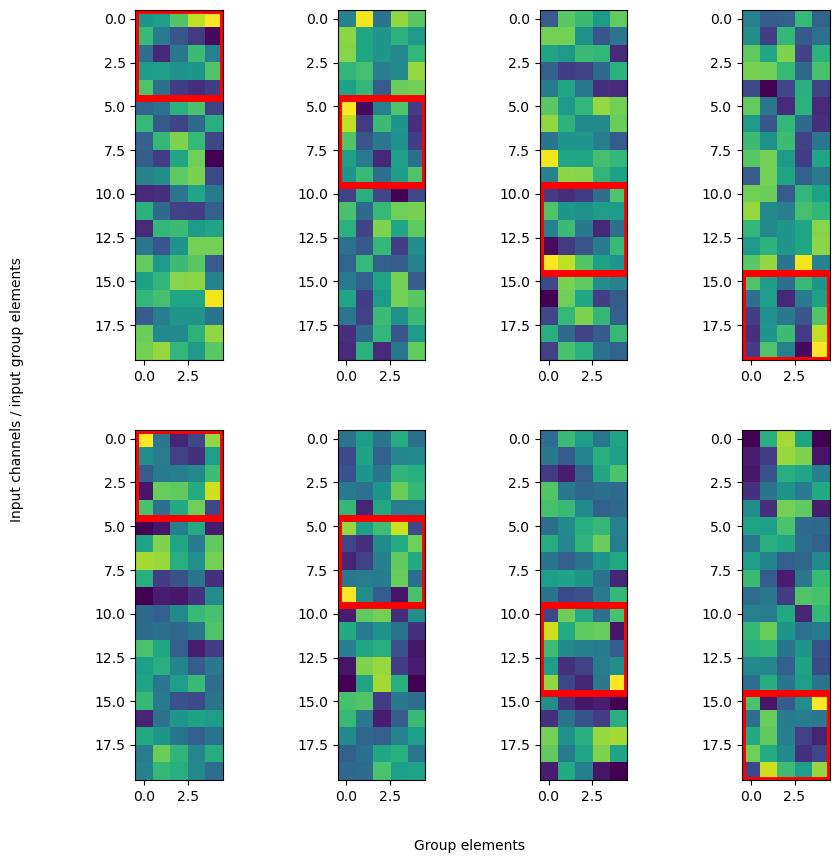

In [30]:
plt.rcParams['figure.figsize'] = [10, 10]

# For ease of viewing, we fold the input group dimension into the spatial x dimension
weights_t = weights.view(
    igk.out_channels,
    igk.group.elements().numel(),
    igk.in_channels,
    igk.group.elements().numel() * igk.kernel_size,
    igk.kernel_size
)

# pick an output channel to visualize
out_channel_idx = 0

# create [in_channels, group_elements] figures
fig, ax = plt.subplots(igk.in_channels, igk.group.elements().numel())

for in_channel in range(igk.in_channels):
    for group_elem in range(igk.group.elements().numel()):
        ax[in_channel, group_elem].imshow(
            weights_t[out_channel_idx, group_elem, in_channel, :, :].cpu().detach()
        )
        
        # Outline the spatial kernel corresponding to the first group element under canonical transformation
        rect = matplotlib.patches.Rectangle(
            (-0.5, group_elem * weights_t.shape[-1] - 0.5), 
            weights_t.shape[-1],
            weights_t.shape[-1],
            linewidth = 5, 
            edgecolor = 'r',
            facecolor = 'none'
        )
        ax[in_channel, group_elem].add_patch(rect)
        
fig.text(0.5, 0.04, 'Group elements', ha = 'center')
fig.text(0.04, 0.5, 'Input channels / input group elements', va = 'center', rotation = 'vertical')

plt.show()

In [31]:
class GroupConvolution(torch.nn.Module):
    
    
    def __init__(self, group, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        
        self.kernel = InterpolativeGroupKernel(
            group = group,
            kernel_size = kernel_size,
            in_channels = in_channels,
            out_channels = out_channels
        )
        
        self.padding = padding
        
        
    def forward(self, x):
        """ Perform group convolution
        
        @param x: Input sample [batch_dim, in_channels, group_dim, spatial_dim_1,
            spatial_dim_2]
        
        @ return: Function on a homogeneous space of the group
            [batch_dim, out_channels, num_group_elements, spatial_dim_1,
             spatial_dim_2]
        """
        
        # We now fold the group dimensions of our input into the input channel
        # dimension.
        x = x.reshape(-1, 
            x.shape[1] * x.shape[2],
            x.shape[3],
            x.shape[4]
        )
        
        # We obtain convolution kernels transformed under the group.
        conv_kernels = self.kernel.sample()
        
        conv_kernels = conv_kernels.reshape(
            self.kernel.out_channels * self.kernel.group.elements().numel(),
            self.kernel.in_channels * self.kernel.group.elements().numel(),
            self.kernel.kernel_size,
            self.kernel.kernel_size,
        )
        
        # Apply group convolution, note that the reshape folds the 'output' group 
        # dimension of the kernel into the output channel dimension, and the 
        # 'input' group dimension into the input channel dimension.
        
        x = torch.nn.functional.conv2d(input = x, 
                                       weight = conv_kernels, 
                                       padding = self.padding)
        
        # Reshape [batch_dim, in_channels * num_group_elements, spatial_dim_1, 
        # spatial_dim_2] into [batch_dim, in_channels, num_group_elements, 
        # spatial_dim_1, spatial_dim_2], separating channel and group 
        # dimensions.
        x = x.view(
            -1,
            self.kernel.out_channels,
            self.kernel.group.elements().numel(),
            x.shape[-1],
            x.shape[-2],
        )
        
        return x

In [32]:
torch.manual_seed(0)

group_conv_layer = GroupConvolution(group=CyclicGroup(order = 4),
                                    in_channels=16, 
                                    out_channels=16,
                                    kernel_size = 5,
                                    padding = 0)

### 2.3 Projection and tying everything together

#### 2.3.1 Group CNN

In [33]:
from torch.nn import AdaptiveAvgPool3d

class GroupEquivariantCNN(torch.nn.Module):
    
    def __init__(self, group, in_channels, out_channels, kernel_size, num_hidden, hidden_channels):
        super().__init__()
        
        # Create the lifting convolution
        self.lifting_conv = LiftingConvolution(group = group, 
                                               in_channels = in_channels, 
                                               out_channels = hidden_channels, 
                                               kernel_size = kernel_size, 
                                               padding=0
                                              )

        # Create a set of group convolutions.
        self.gconvs = torch.nn.ModuleList()
        
        for i in range(num_hidden):
            self.gconvs.append(
                GroupConvolution(
                    group = group, 
                    in_channels = hidden_channels, 
                    out_channels = hidden_channels, 
                    kernel_size = kernel_size, 
                    padding = 0
                )
            )
        
        # Create the projection layer. Hint: check the import at the top of
        # this cell.
        self.projection_layer = torch.nn.AdaptiveAvgPool3d(1)
        
        # And a final linear layer for classification
        self.final_linear = torch.nn.Linear(hidden_channels, out_channels)
    
    def forward(self, x):
        # Lift and disentangle features in the input.
        x = self.lifting_conv(x)
        x = torch.nn.functional.layer_norm(x, x.shape[-4:])
        x = torch.nn.functional.relu(x)
        
        # Apply group convolutions.
        for gconv in self.gconvs:
            x = gconv(x)
            x = torch.nn.functional.layer_norm(x, x.shape[-4:])
            x = torch.nn.functional.relu(x)
            
        # to ensure equivariance, apply max pooling over group and spatial dims
        x = self.projection_layer(x).squeeze()
        
        x = self.final_linear(x)
        return x

#### 2.3.2 Classical CNN

In [34]:
class CNN(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, num_hidden, hidden_channels):
        super().__init__()
        
        self.first_conv = torch.nn.Conv2d(
            in_channels = in_channels,
            out_channels = hidden_channels,
            kernel_size = kernel_size,
            padding = 0
        )
        
        self.convs = torch.nn.ModuleList()
        for i in range(num_hidden):
            self.convs.append(
                torch.nn.Conv2d(
                    in_channels = hidden_channels,
                    out_channels = hidden_channels,
                    kernel_size = kernel_size,
                    padding = 0
                )
            )
            
        self.final_linear = torch.nn.Linear(hidden_channels, out_channels)
        
    def forward(self, x):
        x = self.first_conv(x)
        x = torch.nn.functional.layer_norm(x, x.shape[-3:])
        x = torch.nn.functional.relu(x)
        
        for conv in self.convs:
            x = conv(x)
            x = torch.nn.functional.layer_norm(x, x.shape[-3:])
            x = torch.nn.functional.relu(x)
            
            
        # Apply average pooling over the ramaining spatial dimensions.
        x = torch.nn.functional.adaptive_avg_pool2d(x, 1).squeeze()
        
        x = self.final_linear(x)
        return x

### 3. Experimenting

#### 3.1 Generalization to the group action.

In [35]:
# We normalize the training data
train_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307, ), (0.3081, ))
                                                  ])


# To demonstrate the generalization capabilities our rotation equivariant layers bring, we apply a random
# rotation between 0 and 360 deg to the test set.
test_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.RandomRotation(
                                                     [0, 360],
                                                     torchvision.transforms.InterpolationMode.BILINEAR,
                                                     fill = 0),
                                                 torchvision.transforms.Normalize((0.1307, ), (0.3081, ))
                                                 ])


# We demonstrate our models on the MNIST dataset.
train_ds = torchvision.datasets.MNIST(root = DATASET_PATH, 
                                      train = True, 
                                      transform = train_transform, 
                                      download = True)

test_ds = torchvision.datasets.MNIST(root = DATASET_PATH, 
                                      train = False, 
                                      transform = test_transform)


train_loader = torch.utils.data.DataLoader(train_ds, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = 64, shuffle = False)

# Set the random seed for reproducibility
pl.seed_everything(12)

Global seed set to 12


12

In [36]:
train_ds[0][0].shape

torch.Size([1, 28, 28])

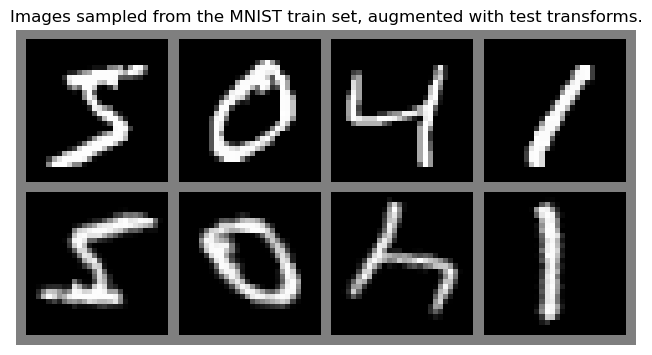

In [37]:
NUM_IMAGES = 4
images = [train_ds[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_ds.data[idx].numpy()) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim = 0), 
                                       nrow = 4, 
                                       normalize = True,
                                       pad_value = 0.5
                                      )
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Images sampled from the MNIST train set, augmented with test transforms.")
plt.imshow(img_grid)
plt.axis('off')
plt.show()

In [38]:
class DataModule(pl.LightningModule):
    
    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs
            model_name - Name of the model/CNN to run. Used for creating the model (see functions below)
            model_hparam - Hyperparameters for the model, as dictionary
            optimize_name - Name of the optimizer to use. Currently supported. Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning_rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        
        
    def forward(self, imgs):
        return self.model(imgs)
    
    def configure_optimizers(self):
        # AdamW is Adam with a correct implementation of weight decay
        optimizer = optim.AdamW(
                                self.parameters(), **self.hparams.optimizer_hparams)
        
        return [optimizer], []
    
    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader
        imgs, labels = batch
        preds = self.model(imgs.to(device))
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim = -1) == labels).float().mean()
        
        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_acc', acc, on_step = False, on_epoch = True)
        self.log('train_loss', loss)
        
        return loss # Return tensor to call ".backward" on
    
    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim = -1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc, prog_bar = True)
        
        
    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs.to(device)).argmax(dim = -1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('test_acc', acc, prog_bar = True)

In [39]:
model_dict = {
    'CNN': CNN,
    'GCNN': GroupEquivariantCNN
}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\".Available models are: {str(model_dict.keys())}"
        

In [40]:
from transformers import TrainingArguments

def train_model(model_name, save_name = None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to looj up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    
    """
    
    if save_name is None:
        save_name = model_name
        
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name), # Where to save the model
                         accelerator='cpu', # We run on a single GPU (if possible)
                         devices = 1,
                         max_epochs = 10,    # How many epochs to train for if no patience is set
                         callbacks = [ModelCheckpoint(save_weights_only = True, mode = 'max', monitor = 'val_acc'), # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                      LearningRateMonitor("epoch")],
                        )
    
    trainer.logger._default_hp_metric = None # Optinal loggin argument that we don't need
    
    # Check wether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    
    if os.path.isfile(pretrained_filename):
        print(f"Found model at {pretrained_filename}, loading...")
        model = DataModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with saved hyperparameters
        
    else:
        pl.seed_everything(12) # To be reproducable
        model = DataModule(model_name, **kwargs)#.to('mps')
        trainer.fit(model, train_loader, test_loader)
        model = DataModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training
        
    # Test best model on test set
    val_result = trainer.test(model.to(device), test_loader, verbose = False)
    result = {'val': val_result[0]['test_acc']}
    
    return model, result

In [55]:
cnn_model, cnn_results = train_model(model_name='CNN',
                                     model_hparams = {'in_channels':1,
                                                      'out_channels': 10,
                                                      'kernel_size': 5,
                                                      'num_hidden': 4,
                                                      'hidden_channels': 32},
                                     optimizer_name = "Adam",
                                     optimizer_hparams = {'lr': 1e-2,
                                                          'weight_decay': 1e-4},
                                     save_name = 'cnn-pretrained'
                                    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 12

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | CNN              | 103 K 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

In [52]:
gcnn_model, gcnn_results = train_model(model_name = 'GCNN',
            model_hparams = {
                'in_channels': 1,
                'out_channels': 10,
                'kernel_size': 5,
                'num_hidden': 4,
                'hidden_channels': 16,# to account for the increase in trainable parameters due to the extra dimension in our feature maps, remove some hidden channels
                'group': CyclicGroup(order = 4).to(device)},
            optimizer_name = 'Adam',
            optimizer_hparams = {'lr': 1e-2,
                                'weight_decay': 1e-4},
            save_name = 'gcnn_pretrained')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 12


cpu



  | Name        | Type                | Params
----------------------------------------------------
0 | model       | GroupEquivariantCNN | 102 K 
1 | loss_module | CrossEntropyLoss    | 0     
----------------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.412     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/temporary/anaconda3/envs/torch_mkl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/temporary/anaconda3/envs/torch_mkl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/Users/temporary/anaconda3/envs/torch_mkl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


cpu


Testing: 0it [00:00, ?it/s]

In [54]:
print(f"CNN - Num Parameters {sum([np.prod(p.shape) for p in cnn_model.parameters()])} - Val Accuracy {cnn_results['val'] * 100.:4.2f}%")
print(f"GCNN - Num Parameters {sum([np.prod(p.shape) for p in gcnn_model.parameters()])} - Val Accuray {gcnn_results['val'] * 100.:4.2f}%")

NameError: name 'cnn_model' is not defined

#### 3.2 Extructing features

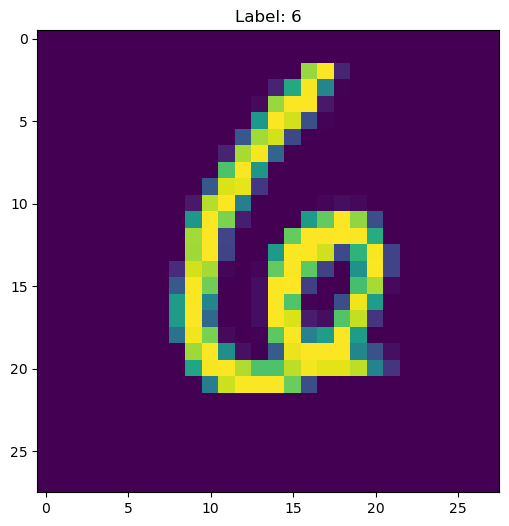

In [41]:
train_ds = torchvision.datasets.MNIST(root = DATASET_PATH, 
                                      train = False, 
                                      transform = None)

# Get an image from the test dataset
digit, label = train_ds[123]

# Turn it to a tensor
digit = transforms.ToTensor()(digit)

plt.figure(figsize=(6, 6))
plt.imshow(digit.squeeze())
plt.title(f"Label: {label}")
plt.show()

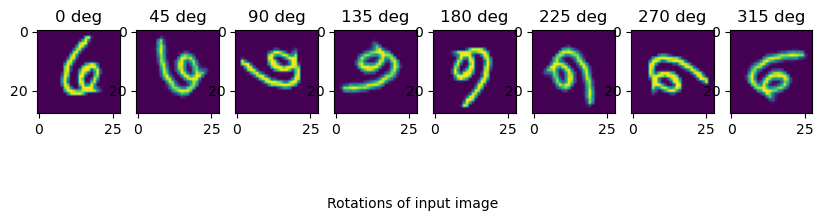

In [44]:
plt.rcParams['figure.figsize'] = (10, 3)

# Get a set of angles to which rotate this image.
rots = torch.linspace(0, 360 - 360/8, 8)

# Rotate the input image and push it through the normalization transform.
rot_digit = torch.stack(tuple(torchvision.transforms.functional.rotate(digit, a.item(), torchvision.transforms.functional.InterpolationMode.BILINEAR) for a in rots))
rot_digit = torchvision.transforms.Normalize((0.1307,), (0.3081, ))(rot_digit)

# Create a subfigure for every rotated input
fig, ax = plt.subplots(1, rots.numel())

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        rot_digit[idx, :, :].squeeze()
    )
    ax[idx].set_title(f"{int(rotation)} deg")
    
    
fig.text(0.5, 0.04, 'Rotations of input image', ha = 'center')

plt.show()

In [48]:
cnn_model = DataModule.load_from_checkpoint('./saved_models/cnn-pretrained/lightning_logs/version_18/checkpoints/epoch=9-step=9380.ckpt')

# Forward it through the first few layers of the CNN 
cnn_out = cnn_model.model.first_conv(rot_digit)
cnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(cnn_out, cnn_out.shape[-3:]))
for i in range(2):
    cnn_out = cnn_model.model.convs[i](cnn_out)
    cnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(cnn_out, cnn_out.shape[-3:]))


# Let's also see what heppens after we apply projection over remaining spatial dimensions.
projection_cnn_out = torch.nn.functional.adaptive_avg_pool2d(cnn_out, 1).squeeze()

gcnn_model = DataModule.load_from_checkpoint('./saved_models/gcnn-pretrained/lightning_logs/version_0/checkpoints/epoch=9-step=9380.ckpt')

# Forward it through the first few layers of the GCNN
gcnn_out = gcnn_model.model.lifting_conv(rot_digit)
gcnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(gcnn_out, gcnn_out.shape[-4:]))
for i in range(2):
    gcnn_out = gcnn_model.model.gconvs[i](gcnn_out)
    gcnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(gcnn_out, gcnn_out.shape[-4:]))

    
# And let's see what happens if we apply the projection on this quivariant representation
projection_gcnn_out = torch.mean(gcnn_out, dim = (-3, -2, -1))

Lightning automatically upgraded your loaded checkpoint from v1.6.1 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file saved_models/cnn-pretrained/lightning_logs/version_18/checkpoints/epoch=9-step=9380.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.6.1 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file saved_models/gcnn-pretrained/lightning_logs/version_0/checkpoints/epoch=9-step=9380.ckpt`


cpu


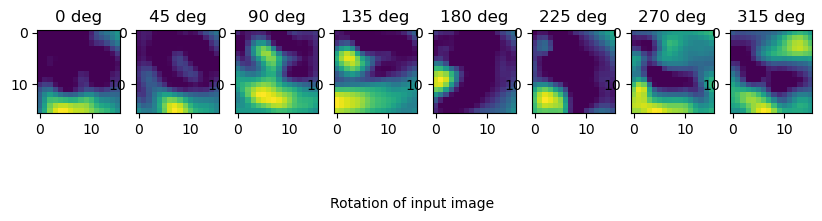

In [50]:
plt.rcParams["figure.figsize"] = [10, 3]

# Pick a shannel to visualize
out_channel_idx = 2

# Create a subfigure for every rotated input
fig, ax = plt.subplots(1, rots.numel())

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        cnn_out[idx, out_channel_idx, :, :].detach().numpy()
    )
    ax[idx].set_title(f"{int(rotation)} deg")
    
fig.text(0.5, 0.04, 'Rotation of input image', ha = 'center')

plt.show()

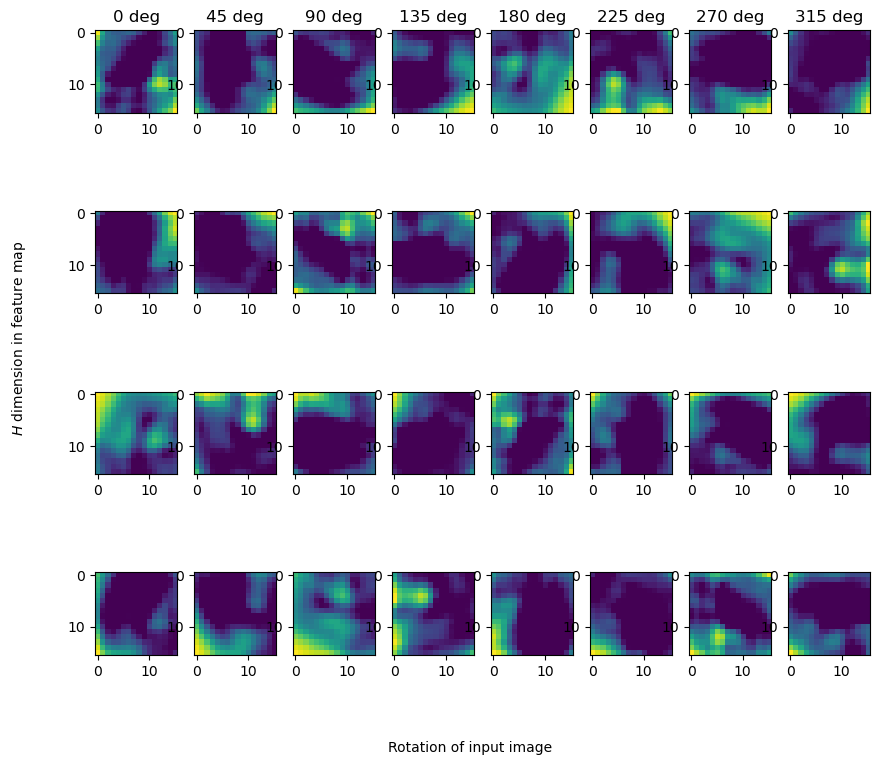

In [53]:
plt.rcParams['figure.figsize'] = [10, 9]

# Pick a channel to visualize
out_channel_idx = 2

# Create a subgroup image for every rotated input and every group element
fig, ax = plt.subplots(gcnn_out.shape[2], rots.numel())

for idx, rotation in enumerate(rots):
    for group_element_idx in range(gcnn_out.shape[2]):
        ax[group_element_idx, idx].imshow(
            gcnn_out[idx, out_channel_idx, group_element_idx, :,  :].detach().numpy()
        )
    ax[0, idx].set_title(f"{int(rotation)} deg")
    
fig.text(0.5, 0.04, 'Rotation of input image', ha = 'center')
fig.text(0.04, 0.5, '$H$ dimension in feature map', va = 'center', rotation = 'vertical')

plt.show()

Text(0.04, 0.5, 'Rotations of input image')

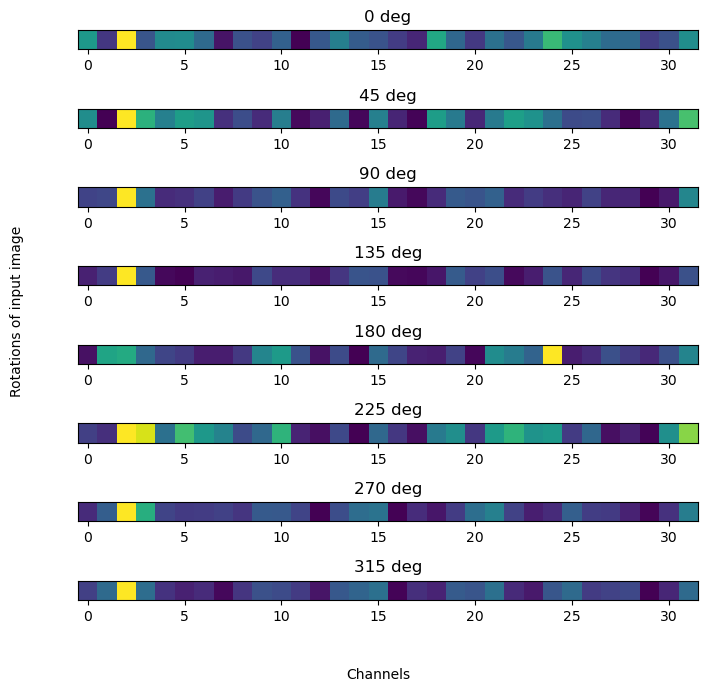

In [56]:
plt.rcParams['figure.figsize'] = [8, 8]

# Create a subfigure for every rotated input
fig, ax = plt.subplots(rots.numel(), 1)

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        projection_cnn_out[idx, None, :].detach().numpy()
    )
    
    ax[idx].set_title(f"{int(rotation)} deg")
    ax[idx].set_yticks([])
    
fig.text(0.5, 0.04, 'Channels', ha = 'center')
fig.text(0.04, 0.5, 'Rotations of input image', va = 'center', rotation = 'vertical')

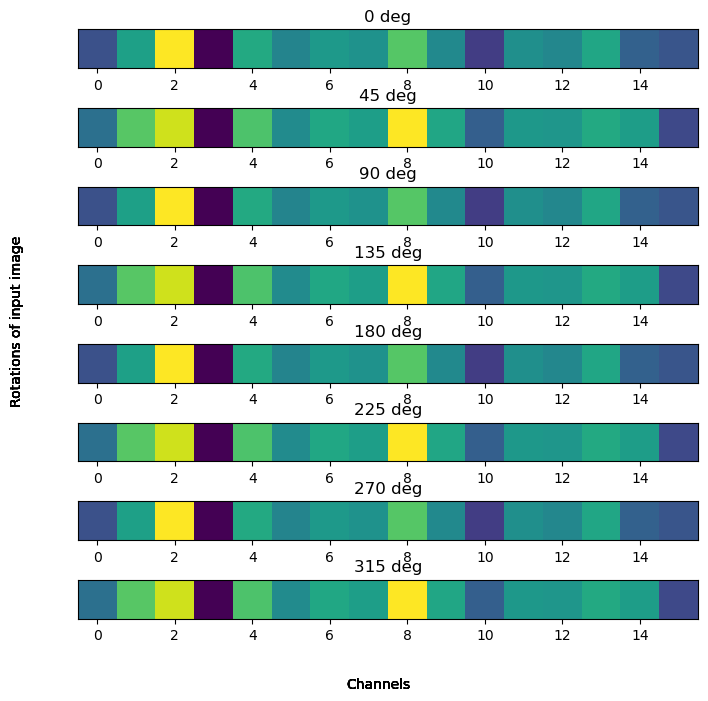

In [58]:
plt.rcParams['figure.figsize'] = [8, 8]

# Create a subfigure for every rotated input
fig, ax = plt.subplots(rots.numel(), 1)

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        projection_gcnn_out[idx, None, :].detach().numpy()
    )
    ax[idx].set_title(f"{int(rotation)} deg")
    ax[idx].set_yticks([])
    
    fig.text(0.5, 0.04, 'Channels', ha = 'center')
    fig.text(0.04, 0.5, 'Rotations of input image', va = 'center', rotation = 'vertical')
    
plt.show()